In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array handling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics
from sklearn.preprocessing import MinMaxScaler  # For scaling numerical data
from sklearn.ensemble import RandomForestRegressor  # Random Forest for regression
from sklearn.svm import SVR  # Support Vector Regression model
from keras.models import Sequential  # Sequential model from Keras
from keras.layers import LSTM, Dense, Dropout  # LSTM and Dense layers for deep learning models
import matplotlib.pyplot as plt  # For data visualization
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of companies for which stock price predictions will be made.
# The data for these companies is expected to be stored in CSV files with the format "<COMPANY_NAME>_data.csv".
companies = ["TESLA_data", "APPLE_data", "GOOGLE_data", "MICROSOFT_data", "AMAZON_data"]

In [3]:
# Feature engineering: Adding new features and handling missing values
def feature_engineering(df):
    # Calculate daily price range (volatility) as a new feature
    # Formula: (High - Low) / Low
    # This indicates the relative daily movement of the stock price
    df['Volatility'] = (df['High'] - df['Low']) / df['Low']
    
    # Handle missing values by backfilling
    # Backfill ('bfill') fills missing values with the next valid observation
    # Ensures no gaps in the data, which is critical for time-series models
    df.fillna(method='bfill', inplace=True)
    
    # Return the modified DataFrame
    return df

In [4]:
# Prepare data for model training and testing
def prepare_data(data, sequence_length):
    # Initialize MinMaxScaler to normalize features into the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Define the features to be normalized
    features = ['Open', 'High', 'Low', 'Volume', 'Volatility']
    
    # Scale the specified features using MinMaxScaler
    data[features] = scaler.fit_transform(data[features])
    
    # Scale the target variable ('Adj Close') separately
    data['Adj Close'] = scaler.fit_transform(data[['Adj Close']])
    
    # Initialize lists to store the sequences (X) and corresponding labels (y)
    X, y = [], []
    
    # Create sequences of `sequence_length` for the features and labels
    for i in range(sequence_length, len(data)):
        # Append the sequence of features for the current window
        X.append(data[features].iloc[i-sequence_length:i].values)
        
        # Append the target value ('Adj Close') for the current time step
        y.append(data['Adj Close'].iloc[i])
    
    # Convert the lists to NumPy arrays for model compatibility
    X, y = np.array(X), np.array(y)
    
    # Return the sequences, labels, and the scaler object
    return X, y, scaler

In [5]:
# Sequentially split the data into training and testing sets
def split_data_sequential(X, y, train_ratio=0.8):
    # Calculate the index at which to split the data
    # The split index is determined by the specified training ratio (default is 80%)
    split_idx = int(len(X) * train_ratio)
    
    # Split the input sequences (X) into training and testing sets
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    # Split the target values (y) into training and testing sets
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Return the training and testing splits
    return X_train, X_test, y_train, y_test

In [6]:
# Build and compile an LSTM model for time-series forecasting
def build_lstm(sequence_length, feature_size):
    # Initialize a Sequential model
    model = Sequential()
    
    # Add the first LSTM layer with 64 units
    # `return_sequences=True` ensures that the layer outputs a sequence for the next LSTM layer
    # `input_shape=(sequence_length, feature_size)` specifies the input dimensions for the model
    model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, feature_size)))
    
    # Add the second LSTM layer with 64 units
    # `return_sequences=False` ensures that this layer outputs the final hidden state only
    model.add(LSTM(64, return_sequences=False))
    
    # Add a Dense layer with 32 neurons and ReLU activation
    # This layer introduces non-linearity to the model
    model.add(Dense(32, activation='relu'))
    
    # Add the output Dense layer with 1 neuron and linear activation
    # This layer outputs a single numerical value (e.g., the predicted stock price)
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    # Optimizer: Adam - adaptive learning rate optimization
    # Loss Function: Mean Squared Error (MSE) - suitable for regression tasks
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Return the compiled model
    return model

In [7]:
# Train an LSTM model and make predictions
def train_lstm(X_train, y_train, X_test, y_test, sequence_length, batch_size=16, epochs=25):
    # Determine the number of features from the training data
    feature_size = X_train.shape[2]
    
    # Build the LSTM model using the helper function
    model = build_lstm(sequence_length, feature_size)
    
    # Train the LSTM model
    # Validation split: 20% of the training data is used for validation
    # `epochs`: Number of passes through the entire dataset
    # `batch_size`: Number of samples per gradient update
    # `verbose=1`: Print progress during training
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Use the trained model to make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Return the predicted values (flattened to a 1D array) and the actual test labels
    return y_pred.flatten(), y_test

In [8]:
# Train and evaluate Support Vector Machine (SVM) and Random Forest (RF) regression models
def train_svm_rf(X, y):
    # Flatten the input sequences for non-sequential models (SVM and Random Forest)
    # Sequential models like LSTM handle 3D input, but non-sequential models require 2D input
    X = X.reshape(X.shape[0], -1)
    
    # Split the data into training and testing sets
    # Use 80% of the data for training and 20% for testing
    train_size = int(len(X) * 0.8)  # Calculate the index for the split
    X_train, X_test = X[:train_size], X[train_size:]  # Split the input features
    y_train, y_test = y[:train_size], y[train_size:]  # Split the target values
    
    # Train the Support Vector Machine (SVM) model
    # SVM uses an RBF kernel for handling non-linear relationships
    svm_model = SVR(kernel='rbf')
    svm_model.fit(X_train, y_train)  # Fit the model on the training data
    svm_pred = svm_model.predict(X_test)  # Predict on the test data
    
    # Train the Random Forest (RF) model
    # Random Forest with 100 decision trees (n_estimators=100)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)  # Fit the model on the training data
    rf_pred = rf_model.predict(X_test)  # Predict on the test data
    
    # Return the test labels and predictions from both models
    return y_test, svm_pred, rf_pred

In [9]:
# Main execution block for model evaluation

# Define the sequence length for the time-series data
# This specifies the number of past time steps used to predict the target variable
sequence_length = 50

# Initialize a dictionary to store evaluation results
# This dictionary will be used to collect metrics for each company and model
results = {
    "Company": [],  # List to store the name of the company
    "Model": [],  # List to store the name of the model (LSTM, SVM, Random Forest)
    "RMSE": [],  # List to store Root Mean Squared Error (RMSE) for each model
    "MAE": [],  # List to store Mean Absolute Error (MAE) for each model
    "R-Squared": []  # List to store R-Squared values for each model
}

         Adj Close        Close         High          Low         Open  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    237.903827   237.903827   243.186438   232.412227   237.966614   
std      54.239260    54.239260    55.699519    52.862388    54.441001   
min     108.099998   108.099998   111.750000   101.809998   103.000000   
25%     199.358330   199.358330   203.084999   194.060005   199.188332   
50%     233.589996   233.589996   238.393326   227.913330   233.463333   
75%     266.244995   266.244995   272.386658   261.009995   267.008331   
max     409.970001   409.970001   414.496674   405.666656   411.470001   

             Volume  
count  1.007000e+03  
mean   1.022346e+08  
std    4.457512e+07  
min    2.940180e+07  
25%    7.089720e+07  
50%    9.444450e+07  
75%    1.225152e+08  
max    6.663786e+08  
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0368 - val_loss: 0.0056
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

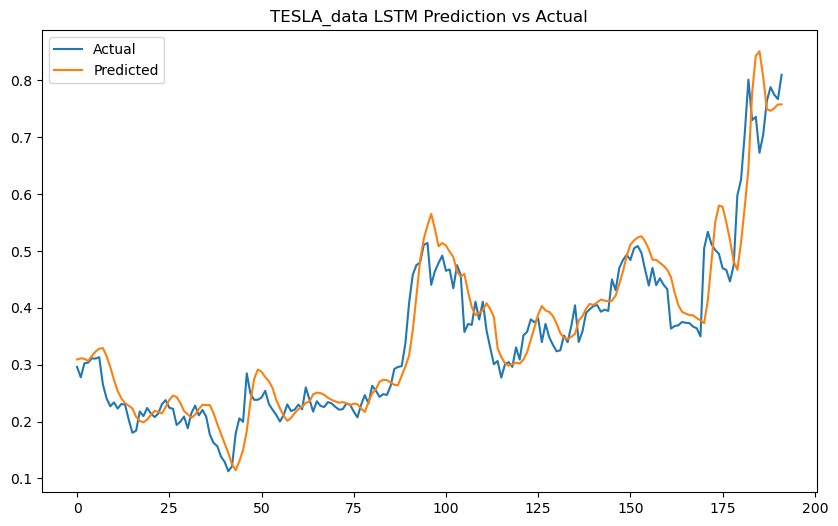

         Adj Close        Close         High          Low         Open  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    164.117775   165.790636   167.402175   164.010278   165.637825   
std      29.593693    28.939357    29.000809    28.819009    28.913878   
min     111.328796   113.849998   115.849998   112.589996   113.910004   
25%     142.260193   144.389999   146.270004   142.549995   143.864998   
50%     162.313187   164.660004   165.850006   162.100006   164.020004   
75%     181.702530   182.404999   184.019997   180.770004   182.295006   
max     236.220108   236.479996   237.490005   234.449997   236.479996   

             Volume  
count  1.007000e+03  
mean   7.523199e+07  
std    3.056541e+07  
min    2.404830e+07  
25%    5.309160e+07  
50%    6.945890e+07  
75%    8.964320e+07  
max    3.186799e+08  
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0237 - val_loss: 0.0022
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

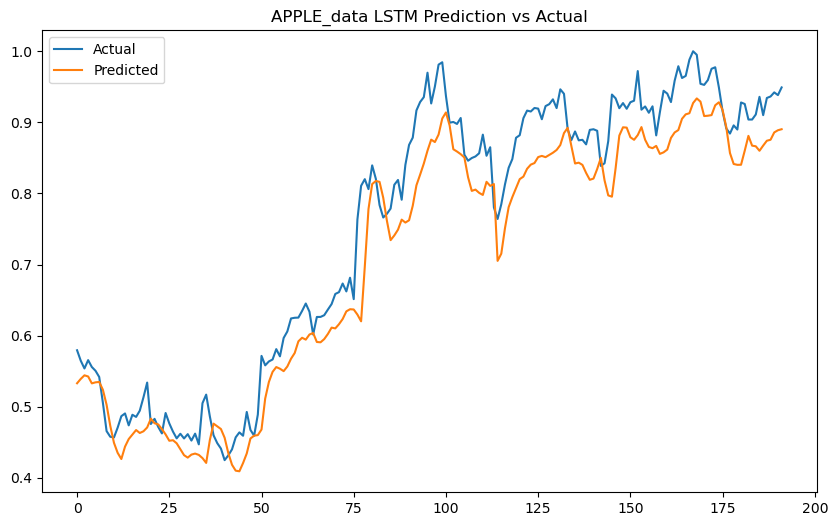

         Adj Close        Close         High          Low         Open  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    128.671268   128.952575   130.328223   127.564351   128.880517   
std      25.259267    25.264239    25.398570    25.173795    25.343560   
min      83.285469    83.489998    86.550003    83.449997    85.131500   
25%     107.523689   107.787750   108.750000   105.709274   107.389999   
50%     129.551834   129.869995   131.559998   128.694504   130.139999   
75%     143.445969   143.798248   145.206497   142.257996   144.153496   
max     192.406723   192.660004   193.309998   190.619995   191.750000   

             Volume  
count  1.007000e+03  
mean   2.500974e+07  
std    1.051457e+07  
min    6.936000e+06  
25%    1.795825e+07  
50%    2.262480e+07  
75%    2.900455e+07  
max    9.779860e+07  
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0218 - val_loss: 0.0016
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

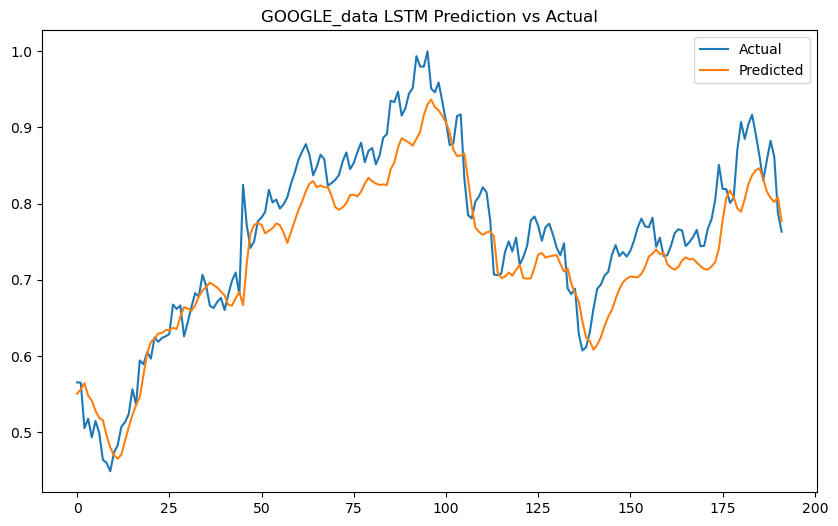

         Adj Close        Close         High          Low         Open  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    309.311128   314.183942   317.079404   311.009523   314.131082   
std      69.302409    67.644231    67.872041    67.347162    67.771586   
min     203.096161   210.110001   212.289993   208.160004   209.589996   
25%     250.434410   255.720001   259.449997   253.215004   256.345001   
50%     292.522675   299.869995   303.230011   297.019989   300.209992   
75%     367.015518   370.059998   373.039993   366.634995   369.150009   
max     465.786438   467.559998   468.350006   464.459992   467.000000   

             Volume  
count  1.007000e+03  
mean   2.651013e+07  
std    1.023515e+07  
min    9.200800e+06  
25%    1.976070e+07  
50%    2.434260e+07  
75%    3.045080e+07  
max    9.042890e+07  
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0154 - val_loss: 0.0079
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

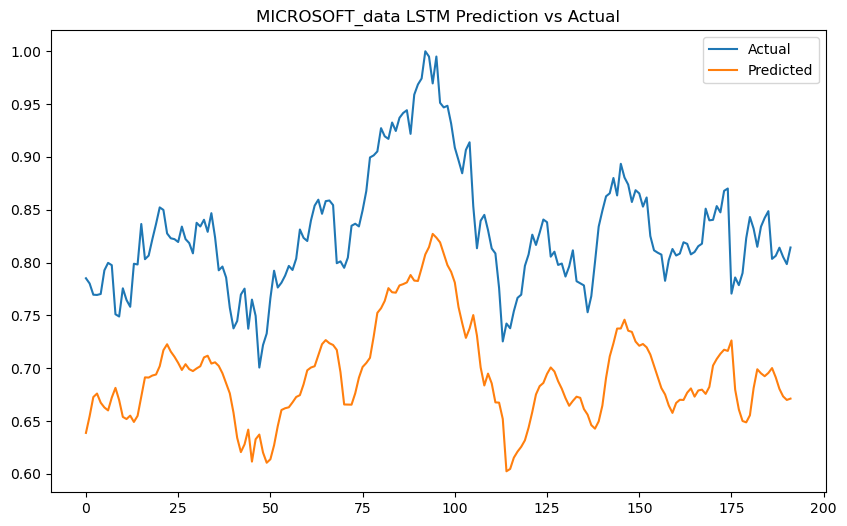

         Adj Close        Close         High          Low         Open  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    148.391130   148.391130   150.205162   146.545366   148.439797   
std      30.252298    30.252298    30.292713    30.217347    30.301663   
min      81.820000    81.820000    83.480003    81.430000    82.800003   
25%     125.944248   125.944248   127.385002   124.070000   125.474998   
50%     155.541000   155.541000   157.602493   153.929993   155.835007   
75%     172.063995   172.063995   173.692749   170.075249   172.026497   
max     214.100006   214.100006   215.899994   210.880005   214.160004   

             Volume  
count  1.007000e+03  
mean   6.180168e+07  
std    2.760537e+07  
min    2.164740e+07  
25%    4.427000e+07  
50%    5.616800e+07  
75%    7.223510e+07  
max    2.726620e+08  
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0527 - val_loss: 0.0024
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

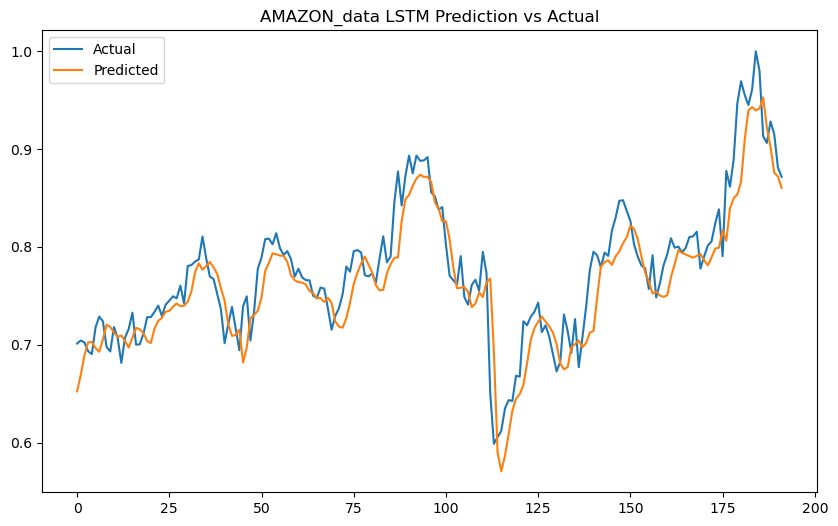


Stock Prediction Evaluation Metrics:
           Company          Model      RMSE       MAE  R-Squared
0       TESLA_data           LSTM  0.046853  0.034027   0.896673
1       TESLA_data            SVM  0.059010  0.045817   0.836095
2       TESLA_data  Random Forest  0.035229  0.023257   0.941584
3       APPLE_data           LSTM  0.055547  0.046880   0.914701
4       APPLE_data            SVM  0.405687  0.329307  -3.549951
5       APPLE_data  Random Forest  0.207528  0.163566  -0.190639
6      GOOGLE_data           LSTM  0.045293  0.037215   0.856512
7      GOOGLE_data            SVM  0.398339  0.360923 -10.098477
8      GOOGLE_data  Random Forest  0.215092  0.187295  -2.235986
9   MICROSOFT_data           LSTM  0.136869  0.134456  -4.750315
10  MICROSOFT_data            SVM  0.301937  0.289858 -26.984308
11  MICROSOFT_data  Random Forest  0.093066  0.075713  -1.658688
12     AMAZON_data           LSTM  0.031035  0.023597   0.810748
13     AMAZON_data            SVM  0.207788  0.19015

In [10]:
# Iterate through each company in the list
for company in companies:
    # Define the file path for the company's dataset
    file_path = company + ".csv"
    
    # Read the dataset, parsing the 'Date' column as datetime
    df = pd.read_csv(file_path, parse_dates=['Date'])
    
    # Set the 'Date' column as the index for time-series processing
    df.set_index('Date', inplace=True)
    
    # Print summary statistics of the dataset for exploratory analysis
    print(df.describe())
    
    # Apply feature engineering (e.g., calculating volatility and handling missing values)
    df = feature_engineering(df)

    # Prepare data for training and testing
    # Generate input sequences (X), target values (y), and a scaler for later inverse transformations
    X, y, scaler = prepare_data(df, sequence_length)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_data_sequential(X, y)

    # Train the LSTM model and generate predictions
    lstm_pred, lstm_actual = train_lstm(X_train, y_train, X_test, y_test, sequence_length)

    # Evaluate the performance of the LSTM model
    lstm_rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_pred))  # Root Mean Squared Error
    lstm_mae = mean_absolute_error(lstm_actual, lstm_pred)  # Mean Absolute Error
    lstm_r2 = r2_score(lstm_actual, lstm_pred)  # R-Squared

    # Store the LSTM results in the results dictionary
    results["Company"].append(company)
    results["Model"].append("LSTM")
    results["RMSE"].append(lstm_rmse)
    results["MAE"].append(lstm_mae)
    results["R-Squared"].append(lstm_r2)

    # Train and evaluate SVM and Random Forest models
    # Note: Input data must be flattened for these non-sequential models
    y_test_flat, svm_pred, rf_pred = train_svm_rf(X, y)

    # Evaluate the SVM model
    svm_rmse = np.sqrt(mean_squared_error(y_test_flat, svm_pred))  # Root Mean Squared Error
    svm_mae = mean_absolute_error(y_test_flat, svm_pred)  # Mean Absolute Error
    svm_r2 = r2_score(y_test_flat, svm_pred)  # R-Squared
    results["Company"].append(company)
    results["Model"].append("SVM")
    results["RMSE"].append(svm_rmse)
    results["MAE"].append(svm_mae)
    results["R-Squared"].append(svm_r2)

    # Evaluate the Random Forest model
    rf_rmse = np.sqrt(mean_squared_error(y_test_flat, rf_pred))  # Root Mean Squared Error
    rf_mae = mean_absolute_error(y_test_flat, rf_pred)  # Mean Absolute Error
    rf_r2 = r2_score(y_test_flat, rf_pred)  # R-Squared
    results["Company"].append(company)
    results["Model"].append("Random Forest")
    results["RMSE"].append(rf_rmse)
    results["MAE"].append(rf_mae)
    results["R-Squared"].append(rf_r2)

    # Plot predictions from the LSTM model
    plt.figure(figsize=(10, 6))
    plt.plot(lstm_actual, label='Actual')  # Plot actual values
    plt.plot(lstm_pred, label='Predicted')  # Plot predicted values
    plt.title(f"{company} LSTM Prediction vs Actual")  # Title with company name
    plt.legend()  # Add legend to distinguish lines
    plt.show()  # Display the plot

# Convert the results dictionary into a DataFrame for better visualization and analysis
results_df = pd.DataFrame(results)

# Print the results DataFrame
print("\nStock Prediction Evaluation Metrics:")
print(results_df)

In [12]:
# Main Execution for Combined Dataset
sequence_length = 50  # Define the sequence length for time-series data

# Initialize an empty DataFrame to store the combined data from all companies
combined_df = pd.DataFrame()

# Iterate through each company in the list
for company in companies:
    # Define the file path for the company's dataset
    file_path = company + ".csv"
    
    # Read the dataset, parsing the 'Date' column as datetime
    df = pd.read_csv(file_path, parse_dates=['Date'])
    
    # Set the 'Date' column as the index for time-series processing
    df.set_index('Date', inplace=True)
    
    # Apply feature engineering (e.g., calculating volatility and handling missing values)
    df = feature_engineering(df)
    
    # Concatenate the processed company data into the combined DataFrame
    combined_df = pd.concat([combined_df, df])

In [ ]:
# Prepare combined data
# Generate input sequences (X), target values (y), and a scaler from the combined dataset
X, y, scaler = prepare_data(combined_df, sequence_length)

# Sequential data split
# Split the combined data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = split_data_sequential(X, y)

# Train LSTM
# Train the LSTM model on the combined dataset and generate predictions for the test data
lstm_pred, lstm_actual = train_lstm(X_train, y_train, X_test, y_test, sequence_length)

# Evaluate LSTM model
# Calculate evaluation metrics for the LSTM model
lstm_rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_pred))  # Root Mean Squared Error
lstm_mae = mean_absolute_error(lstm_actual, lstm_pred)  # Mean Absolute Error
lstm_r2 = r2_score(lstm_actual, lstm_pred)  # R-Squared

# Print LSTM model evaluation metrics
print(f"LSTM - RMSE: {lstm_rmse}, MAE: {lstm_mae}, R-Squared: {lstm_r2}")

# Train and evaluate SVM and Random Forest
# Train SVM and Random Forest models on the combined dataset and generate predictions for the test data
y_test_flat, svm_pred, rf_pred = train_svm_rf(X, y)

# Evaluate SVM model
# Calculate evaluation metrics for the SVM model
svm_rmse = np.sqrt(mean_squared_error(y_test_flat, svm_pred))  # Root Mean Squared Error
svm_mae = mean_absolute_error(y_test_flat, svm_pred)  # Mean Absolute Error
svm_r2 = r2_score(y_test_flat, svm_pred)  # R-Squared

# Print SVM model evaluation metrics
print(f"SVM - RMSE: {svm_rmse}, MAE: {svm_mae}, R-Squared: {svm_r2}")

# Evaluate Random Forest model
# Calculate evaluation metrics for the Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_test_flat, rf_pred))  # Root Mean Squared Error
rf_mae = mean_absolute_error(y_test_flat, rf_pred)  # Mean Absolute Error
rf_r2 = r2_score(y_test_flat, rf_pred)  # R-Squared

# Print Random Forest model evaluation metrics
print(f"Random Forest - RMSE: {rf_rmse}, MAE: {rf_mae}, R-Squared: {rf_r2}")

# Plot predictions for LSTM
# Visualize the LSTM model predictions against the actual values
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(lstm_actual, label='Actual')  # Plot actual values
plt.plot(lstm_pred, label='Predicted')  # Plot predicted values
plt.title("Combined Dataset LSTM Prediction vs Actual")  # Add a title
plt.legend()  # Add a legend to distinguish lines
plt.show()  # Display the plot

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.9933e-04 - val_loss: 0.0024
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.9494e-04 - val_loss: 0.0027
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.8797e-04 - val_loss: 0.0027
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.0344e-04 - val_loss: 0.0013
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.0260e-04 - val_loss: 0.0049
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.8887e-04 - val_loss: 0.0011
Epoch 9/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.6767e-04 - val_loss: 0.0012
Epoch 10/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.9443e-04 - val_loss: 0.0012
Epoch 11/25
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2717e-04